# <center> Crop Yield Prediction — Data Preprocessing & Exploratory Data Analysis (EDA)</center>

- Author: Denish Trada
- Date: 25th May, 2025

##  Table of Contents

1. [Introduction](#1-introduction)  
2. [Importing Libraries](#2-importing-libraries)  
3. [Load Cleaned Dataset](#3-load-cleaned-dataset)  
4. [Sanity Checks](#4-sanity-checks)  
5. [Feature Role Matrix](#5-feature-role-matrix)  
6. [Preprocessing Steps](#6-preprocessing-steps)  
7. [Univariate Analysis](#7-univariate-analysis)  
8. [Bivariate Analysis](#8-bivariate-analysis)  
9. [Correlation Analysis](#9-correlation-analysis)  
10. [Advanced Statistical Testing](#10-advanced-statistical-testing)  
    - [Chi-Square Test](#chi-square-test-of-independence)  
    - [ANOVA Test](#anova-test--yield-differences-across-categories)  
    - [Mutual Information](#mutual-information--feature-importance-non-linear-dependency)  
    - [KMeans Clustering](#kmeans-clustering--agro-environmental-segmentation)  
11. [Final Insights & Modeling Implications](#10-final-insights--modeling-implications)


---
<a id="Introduction"></a>
## 1. Introduction

After completing the data wrangling process and ensuring data quality, this notebook focuses on **Preprocessing** and **Exploratory Data Analysis (EDA)**. This phase is critical in understanding relationships between features and the target variable — `Yield_tons_per_hectare` — and preparing the data for modeling.

###  Objectives
- Identify and encode feature types (categorical, binary, continuous)
- Explore the distribution of each feature independently
- Uncover trends and patterns in crop yield relative to soil type, weather, irrigation, and more
- Understand feature importance through visual and statistical exploration
- Build foundational insight for upcoming feature engineering and modeling

###  Why It Matters
Properly exploring and preprocessing the dataset not only improves model performance but also provides **business and domain context** to drive strategic agricultural insights.

By the end of this notebook, we will have a fully profiled and encoded dataset, with preliminary hypotheses about which factors most significantly affect crop yield.

In [9]:
# Core libraries
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Encoding
from sklearn.preprocessing import LabelEncoder

# Config settings
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

# Plot aesthetics
sns.set(style="whitegrid")

<a id="load"></a>
## 3. Load Cleaned Dataset

We now load the cleaned dataset exported from the previous notebook. This file should contain all rows and columns that passed our quality checks, including removal of duplicates and invalid entries.

This step will help:
- Verify structure and size
- Reconfirm that datatypes are preserved
- Get a preview of the data as we begin preprocessing and EDA


In [20]:
# Load cleaned dataset
df = pd.read_csv("cleaned_agriculture_yield.csv")

# Basic shape and structure
print(f"Dataset Shape: {df.shape}")
df.head()

Dataset Shape: (999769, 10)


,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,west,sandy,cotton,897.08,27.68,False,True,cloudy,122,6.56
1,south,clay,rice,992.67,18.03,True,True,rainy,140,8.53
2,north,loam,barley,148.00,29.79,False,False,sunny,106,1.13
3,north,sandy,soybean,986.87,16.64,False,True,rainy,146,6.52
4,south,silt,wheat,730.38,31.62,True,True,cloudy,110,7.25


In [22]:
# Quick overview of columns and types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 999769 entries, 0 to 999768
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   Region                  999769 non-null  object 
 1   Soil_Type               999769 non-null  object 
 2   Crop                    999769 non-null  object 
 3   Rainfall_mm             999769 non-null  float64
 4   Temperature_Celsius     999769 non-null  float64
 5   Fertilizer_Used         999769 non-null  bool   
 6   Irrigation_Used         999769 non-null  bool   
 7   Weather_Condition       999769 non-null  object 
 8   Days_to_Harvest         999769 non-null  int64  
 9   Yield_tons_per_hectare  999769 non-null  float64
dtypes: bool(2), float64(3), int64(1), object(4)
memory usage: 62.9+ MB


<a id="sanity"></a>
## 4. Sanity Checks

Before diving into transformations and visualizations, we conduct a few final sanity checks on the cleaned dataset to ensure:

- No unexpected null values
- All columns have expected data types
- Each categorical column has a manageable number of unique values
- Boolean columns are indeed binary


In [28]:
# Confirm nulls
print("Missing Values by Column:\n")
print(df.isnull().sum())

# Confirm data types
print("\nColumn Data Types:\n")
print(df.dtypes)


Missing Values by Column:

Region                    0
Soil_Type                 0
Crop                      0
Rainfall_mm               0
Temperature_Celsius       0
Fertilizer_Used           0
Irrigation_Used           0
Weather_Condition         0
Days_to_Harvest           0
Yield_tons_per_hectare    0
dtype: int64

Column Data Types:

Region                     object
Soil_Type                  object
Crop                       object
Rainfall_mm               float64
Temperature_Celsius       float64
Fertilizer_Used              bool
Irrigation_Used              bool
Weather_Condition          object
Days_to_Harvest             int64
Yield_tons_per_hectare    float64
dtype: object


In [30]:
# Count of unique values for each categorical column
cat_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

for col in cat_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].value_counts())



Unique values in 'Region':
Region
north    250112
west     250014
south    250001
east     249642
Name: count, dtype: int64

Unique values in 'Soil_Type':
Soil_Type
sandy     167081
loam      166757
chalky    166735
silt      166633
clay      166311
peaty     166252
Name: count, dtype: int64

Unique values in 'Crop':
Crop
maize      166785
rice       166754
barley     166727
wheat      166640
cotton     166548
soybean    166315
Name: count, dtype: int64

Unique values in 'Weather_Condition':
Weather_Condition
sunny     333701
rainy     333491
cloudy    332577
Name: count, dtype: int64


 <a id="roles"></a>
## 5. Feature Role Matrix


To guide preprocessing and modeling, we categorize each feature by its data type and functional role. This helps ensure appropriate encoding, transformation, and treatment in later stages.

| Feature                | Data Type | Description                          | Role          |
|------------------------|-----------|--------------------------------------|---------------|
| `Region`               | Object    | Geographic zone                      | Categorical   |
| `Soil_Type`            | Object    | Soil classification                  | Categorical   |
| `Crop`                 | Object    | Crop being cultivated                | Categorical   |
| `Rainfall_mm`          | Float     | Seasonal rainfall (mm)               | Continuous    |
| `Temperature_Celsius`  | Float     | Avg. temperature during growth (°C)  | Continuous    |
| `Days_to_Harvest`      | Int       | Total days to harvest                | Continuous    |
| `Fertilizer_Used`      | Boolean   | Whether fertilizer was used          | Binary        |
| `Irrigation_Used`      | Boolean   | Whether irrigation was applied       | Binary        |
| `Weather_Condition`    | Object    | General weather summary              | Categorical   |
| `Yield_tons_per_hectare` | Float   | **Target**: Yield output per hectare | Target        |

This matrix informs:
- Label encoding for categorical features
- Numerical scaling or binning
- Treatment of binary indicators
- Modeling strategy based on variable types


<a id="preprocessing"></a>
## 6. Preprocessing Steps

Before we proceed to visualization and deeper analysis, we need to ensure all features are in formats compatible with correlation analysis and future machine learning models.

### Preprocessing Actions:
- **Label Encode** categorical features: `Region`, `Soil_Type`, `Crop`, `Weather_Condition`
- **Confirm Boolean Columns**: Ensure `Fertilizer_Used` and `Irrigation_Used` are true binary flags
- **Retain a copy of encoded data**: We'll use this version for correlation heatmaps and regression modeling later


In [38]:
# Creating a copy for encoding
df_encoded = df.copy()

# Initializing label encoder
le = LabelEncoder()
cat_features = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

# Applied encoding
for col in cat_features:
    df_encoded[col] = le.fit_transform(df_encoded[col])

# Preview encoded data
df_encoded.head()

,Region,Soil_Type,Crop,Rainfall_mm,Temperature_Celsius,Fertilizer_Used,Irrigation_Used,Weather_Condition,Days_to_Harvest,Yield_tons_per_hectare
0,3,4,1,897.08,27.68,False,True,0,122,6.56
1,2,1,3,992.67,18.03,True,True,1,140,8.53
2,1,2,0,148.00,29.79,False,False,2,106,1.13
3,1,4,4,986.87,16.64,False,True,1,146,6.52
4,2,5,5,730.38,31.62,True,True,0,110,7.25


### Label Encoding Summary

We applied **Label Encoding** to the following categorical features:

- `Region`
- `Soil_Type`
- `Crop`
- `Weather_Condition`

Each category was replaced by a corresponding numeric label using `LabelEncoder` from `sklearn`. This approach ensures compatibility with correlation analysis and basic machine learning algorithms, while preserving ordinal structure where applicable.

For example:
- `Region` values might have been transformed like: `north → 0`, `south → 1`, etc.
- `Crop`: Each crop name is assigned a unique numeric code
- `Weather_Condition`: Conditions like `sunny`, `cloudy`, `rainy` become integers

### Result:
As seen in the preview, all encoded columns now contain integers, making them ready for:
- Visual correlation analysis
- Model training
- One-hot encoding later (if required for specific algorithms)

>  Note: Label encoding introduces a numeric order — not all models interpret this as categorical unless explicitly handled. For linear models, one-hot encoding may be considered later.


In [40]:
# Confirming binary encoding
print("Boolean Column Summary:\n")
for col in ['Fertilizer_Used', 'Irrigation_Used']:
    print(f"{col}: {df_encoded[col].unique()}")


Boolean Column Summary:

Fertilizer_Used: [False  True]
Irrigation_Used: [ True False]


###  Boolean Column Validation

We confirmed that both binary indicator columns are correctly encoded as `True` or `False` values:

- `Fertilizer_Used`: [False, True]  
- `Irrigation_Used`: [True, False]

These values are consistent and usable in both exploratory visualizations and machine learning models without requiring additional conversion.

> No further action is needed for binary variables at this stage.


<a id="univariate"></a>
## 7. Univariate Analysis


In this section, we explore the individual distribution of each feature.

This analysis helps us understand:
- Distribution shape (normal, skewed, uniform)
- Range and central tendencies
- Frequency of categorical values
- Potential anomalies or sparsity in feature values

We'll use:
- **Histograms** and **KDE plots** for numeric features
- **Countplots** for categorical and binary features


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

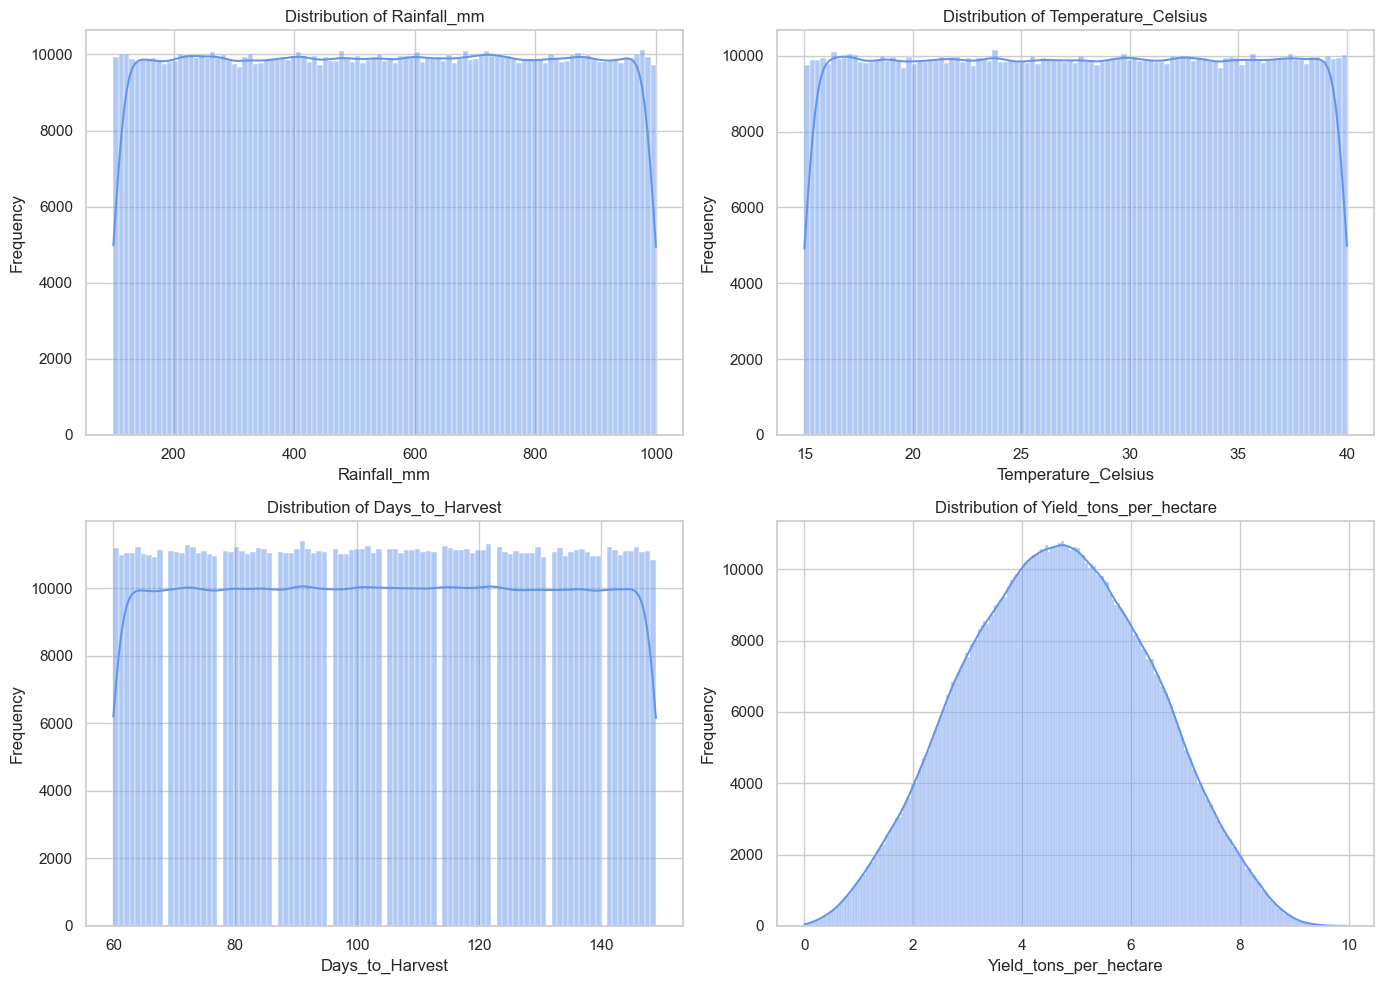

In [47]:
# Defining numeric columns
numeric_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest', 'Yield_tons_per_hectare']

# Plotting histograms
plt.figure(figsize=(14, 10))

for i, col in enumerate(numeric_cols):
    plt.subplot(2, 2, i + 1)
    sns.histplot(df_encoded[col], kde=True, color='cornflowerblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


###  Numeric Feature Distribution

The histograms for the four continuous variables reveal the following patterns:

- **`Rainfall_mm`, `Temperature_Celsius`, `Days_to_Harvest`**:
  - All three show a **uniform distribution**.
  - This suggests the dataset was likely **synthetically generated or balanced** to represent a wide range of scenarios evenly.
  - Useful for minimizing sampling bias across different environmental conditions.

- **`Yield_tons_per_hectare` (Target Variable)**:
  - Displays a **bell-shaped, near-normal distribution**.
  - Centered around ~4.5 tons/ha, which aligns with the earlier summary statistics.
  - No zero or negative values — confirming that previous cleaning steps were effective.

 These distributions confirm high data quality and support a broad, unbiased view of agricultural productivity under varied inputs.


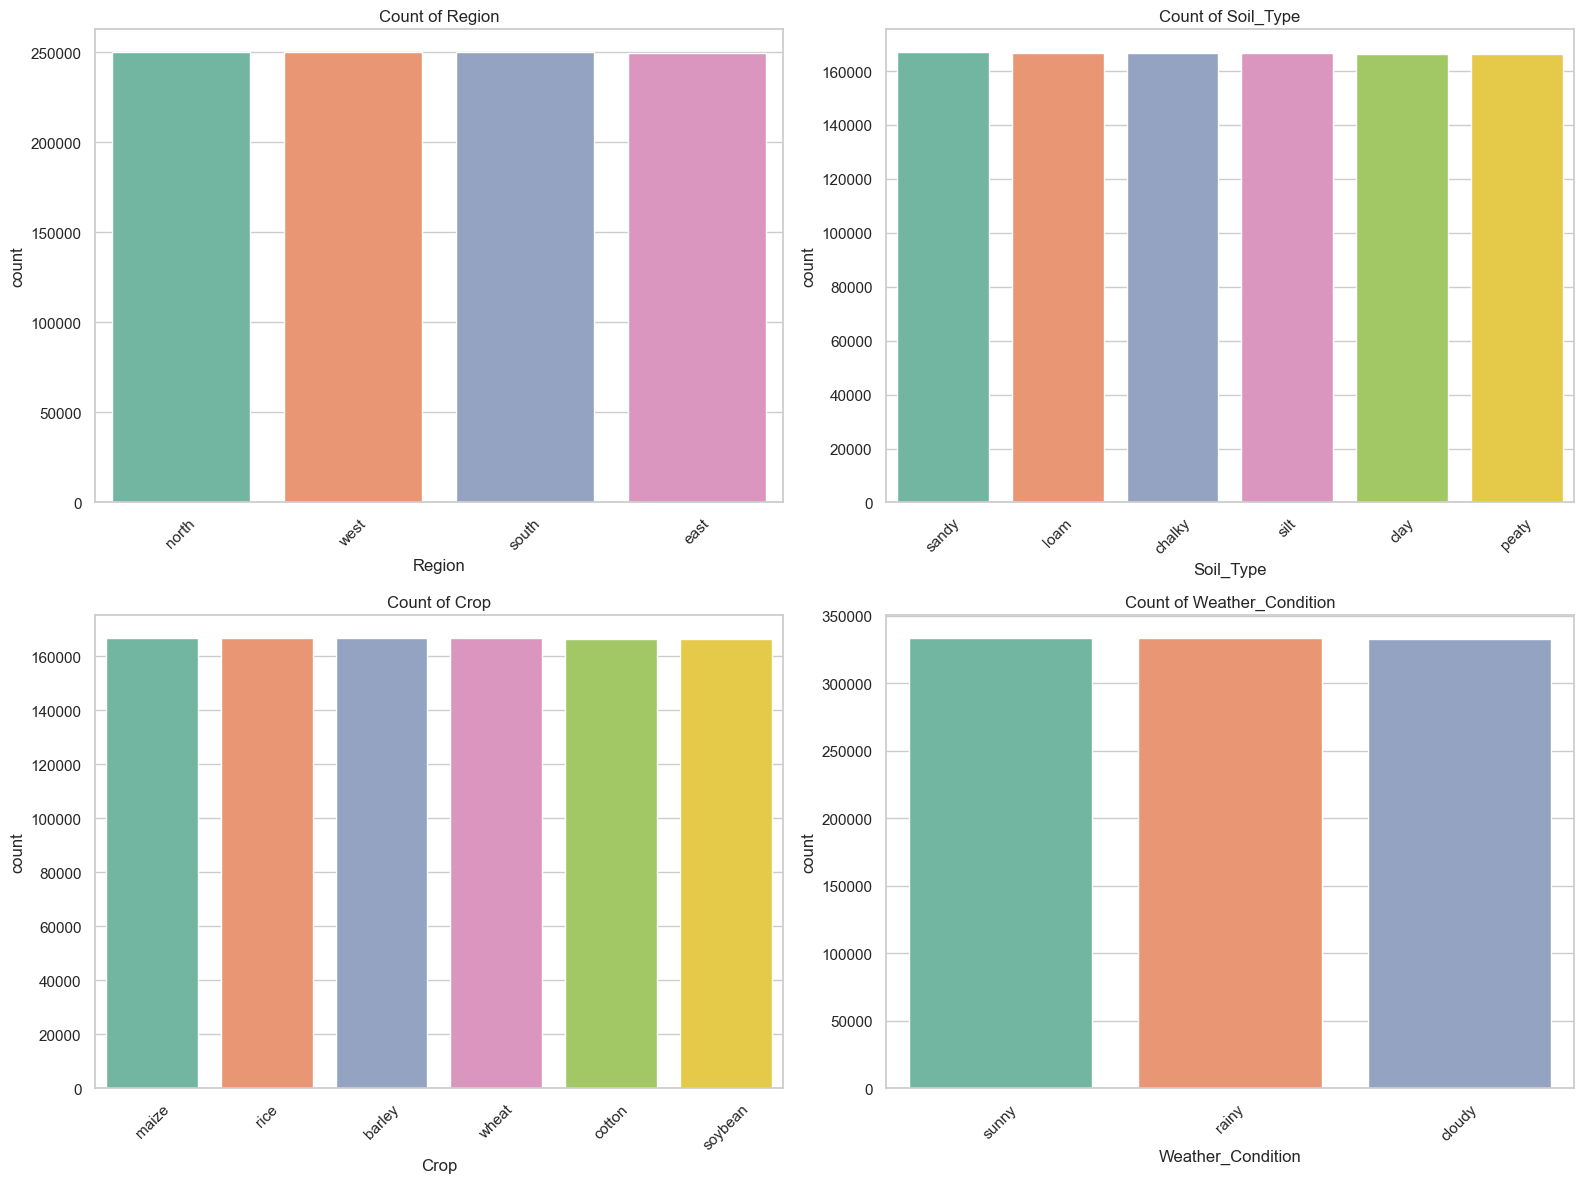

In [49]:
# Defining categorical columns
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

plt.figure(figsize=(16, 12))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i + 1)
    sns.countplot(data=df, x=col, order=df[col].value_counts().index, palette='Set2')
    plt.title(f'Count of {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Categorical Feature Distribution

The countplots for all categorical variables (`Region`, `Soil_Type`, `Crop`, and `Weather_Condition`) reveal:

- **Balanced Representation**:
  - Each `Region` (north, south, east, west) appears equally across the dataset.
  - `Soil_Type` and `Crop` categories also show near-equal distribution.
  - Weather conditions (`sunny`, `rainy`, `cloudy`) are proportionally balanced.

- **No Class Imbalance**:
  - No category is over- or under-represented, which helps reduce model bias and improves generalization.
  - This balance ensures that the model does not favor or ignore specific groups during training.

 These distributions are ideal for downstream modeling and allow for fair evaluation across geographic and agricultural diversity.


<a id="bivariate"></a>
## 8. Bivariate Analysis

To understand what drives crop yield, we analyze relationships between individual features and the target variable (`Yield_tons_per_hectare`).

This includes:
-  Boxplots for categorical features to visualize yield distribution across categories
-  Scatter and violin plots for continuous variables to examine trends and variation

This step provides direct insight into which features are likely to be **strong predictors** in modeling.


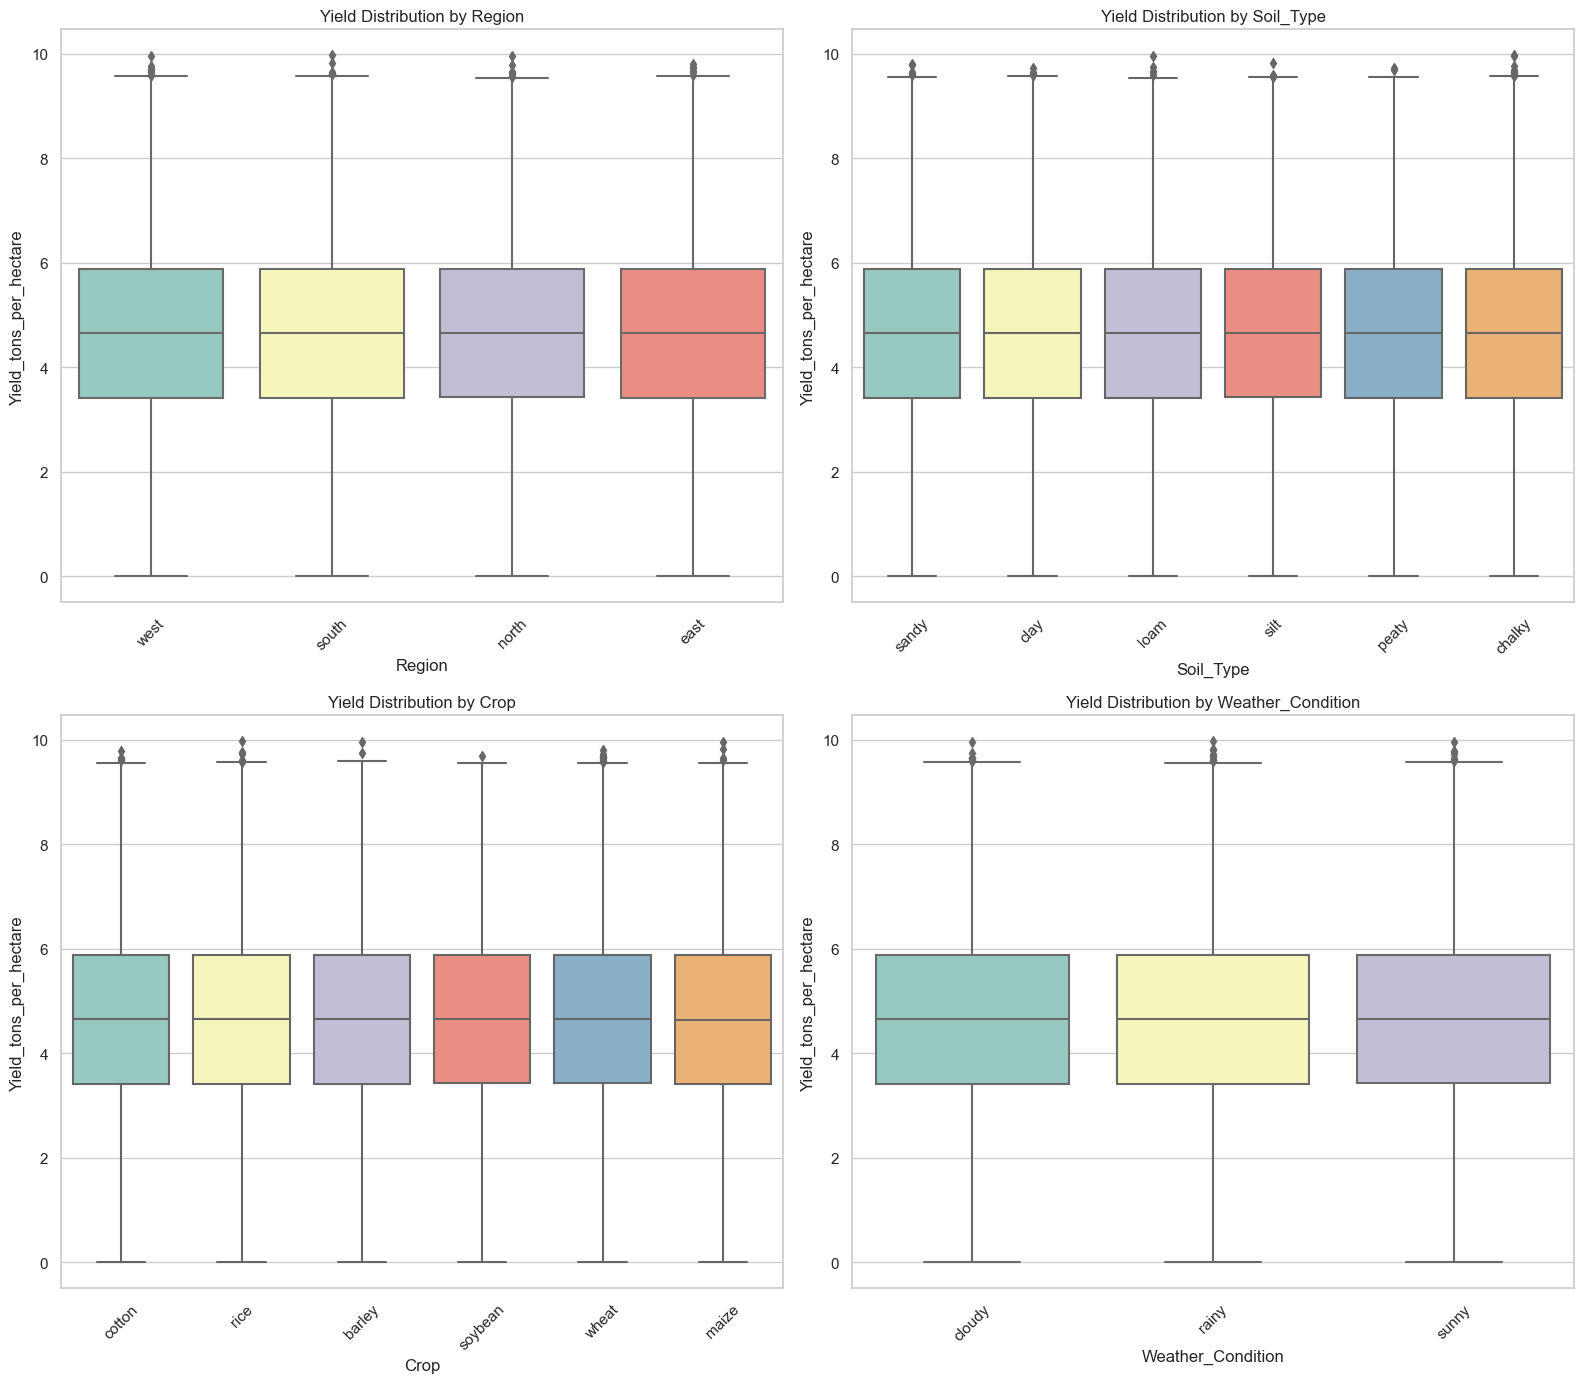

In [58]:
# Defining key categorical variables
categorical_cols = ['Region', 'Soil_Type', 'Crop', 'Weather_Condition']

plt.figure(figsize=(16, 14))

for i, col in enumerate(categorical_cols):
    plt.subplot(2, 2, i + 1)
    sns.boxplot(data=df, x=col, y='Yield_tons_per_hectare', palette='Set3')
    plt.title(f'Yield Distribution by {col}')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


###  Yield Distribution by Categorical Features

We used boxplots to visualize how crop yield varies across the following categorical variables: `Region`, `Soil_Type`, `Crop`, and `Weather_Condition`.

####  Observations:

- **Region**:  
  Yield is relatively consistent across all regions. However, the *East* region shows a slightly higher median yield, while *South* exhibits a wider spread of values. No region stands out with significantly lower or higher performance.

- **Soil_Type**:  
  All soil types display similar yield distributions, but *chalky* and *peaty* soils appear to have slightly higher median yields. Most soil types show a balanced range with a few high-end outliers.

- **Crop**:  
  Yields are tightly clustered for all crops, with **soybean** and **maize** showing marginally better median performance than **barley** or **cotton**. The range and variability suggest some crops may respond better to environmental inputs.

- **Weather_Condition**:  
  Surprisingly, the **rainy** condition appears to support slightly higher median yield than **sunny** or **cloudy** conditions. This insight aligns with the known agricultural dependency on adequate water availability.

####  Implication for Modeling:
These categorical features may not be highly predictive in isolation, but when combined with continuous inputs like rainfall and fertilizer use, they could interact meaningfully. Encoding these as categorical variables preserves important contextual variation.


/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)
/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning

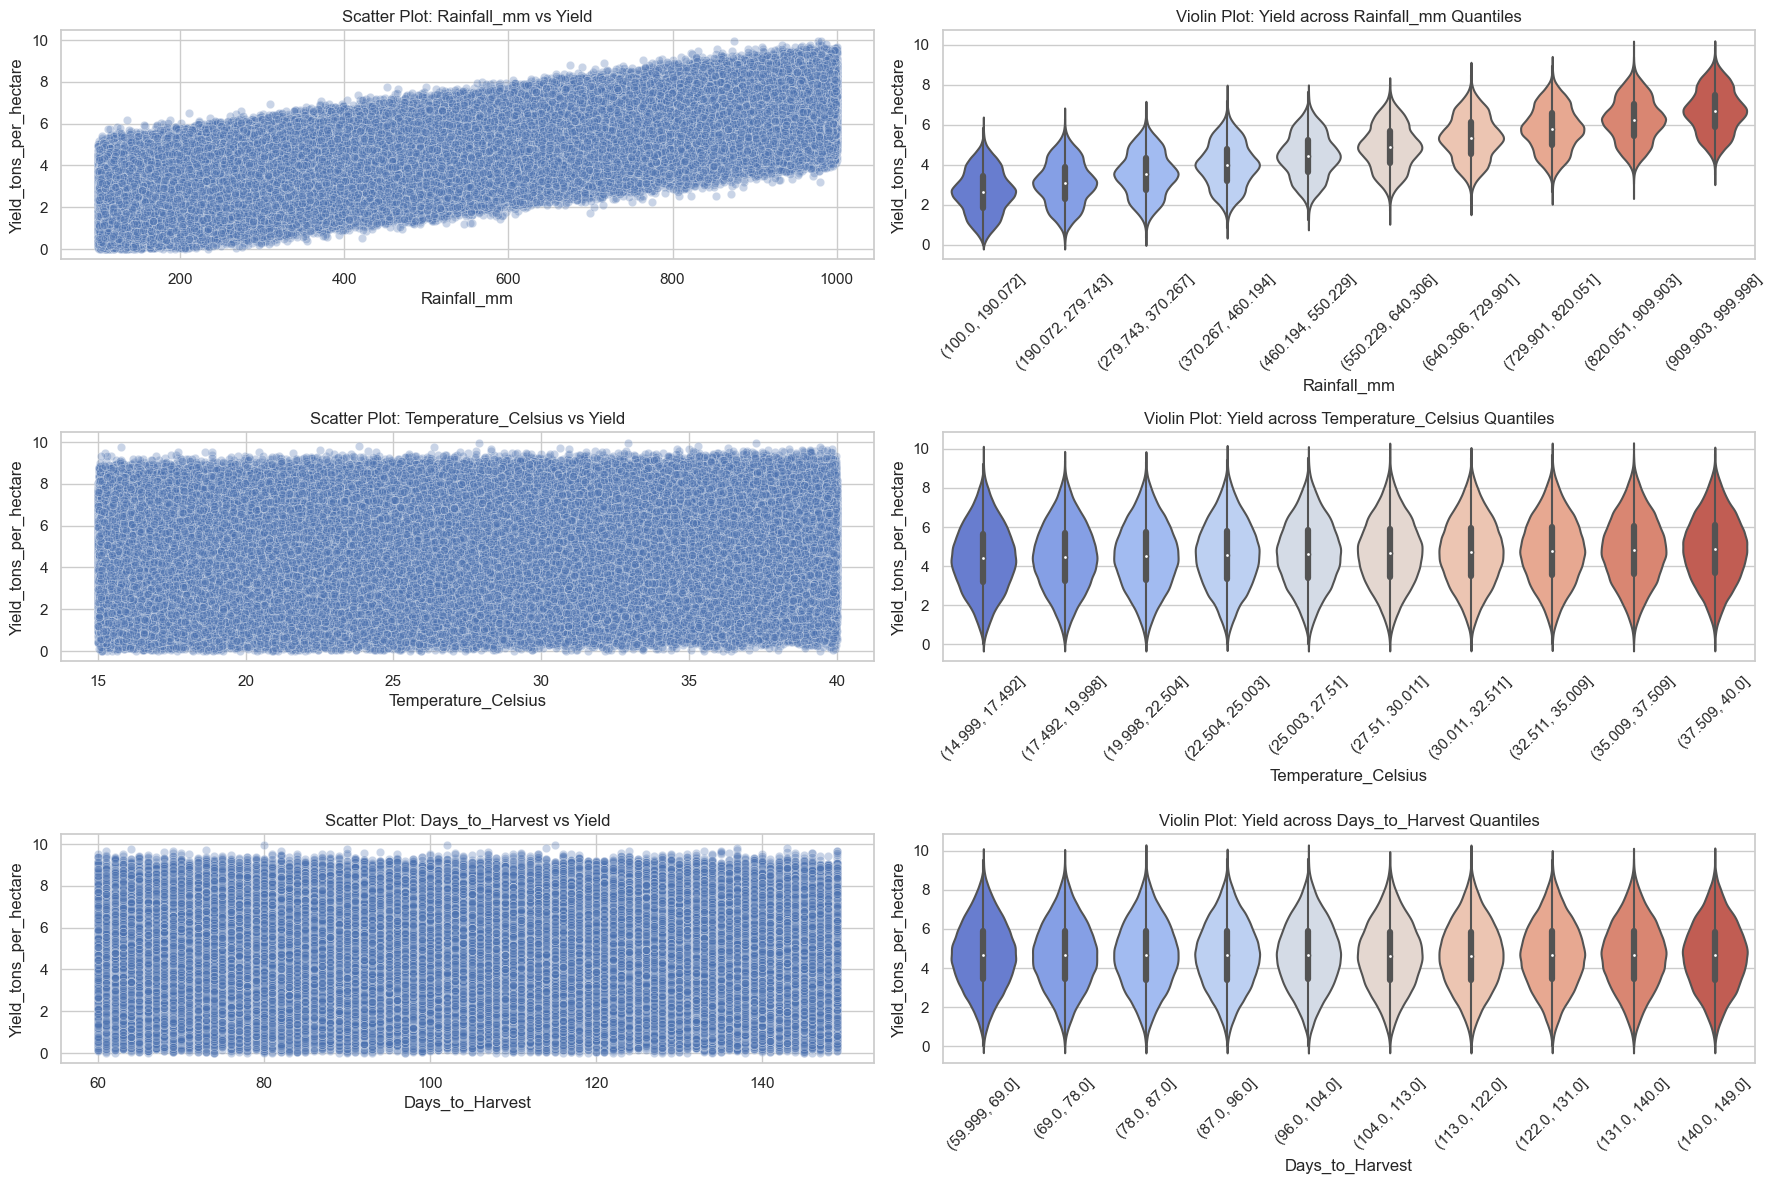

In [60]:
# Plotting relationships between continuous features and yield
continuous_cols = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']

plt.figure(figsize=(18, 12))

for i, col in enumerate(continuous_cols):
    plt.subplot(3, 2, 2*i + 1)
    sns.scatterplot(data=df, x=col, y='Yield_tons_per_hectare', alpha=0.3)
    plt.title(f'Scatter Plot: {col} vs Yield')

    plt.subplot(3, 2, 2*i + 2)
    sns.violinplot(data=df, x=pd.qcut(df[col], 10), y='Yield_tons_per_hectare', inner='box', palette='coolwarm')
    plt.title(f'Violin Plot: Yield across {col} Quantiles')
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


###  Yield Relationship with Continuous Features

We used scatterplots and violin plots to examine how `Yield_tons_per_hectare` varies with:

- `Rainfall_mm`
- `Temperature_Celsius`
- `Days_to_Harvest`

####  Observations:

- **Rainfall_mm**:
  - Clear **positive linear trend** between rainfall and yield in the scatterplot.
  - Violin plot shows rising median yield as rainfall increases.
  - Suggests rainfall is a **strong predictor** of crop yield — more rainfall generally leads to better outcomes, up to an optimal range.

- **Temperature_Celsius**:
  - Moderate, slightly **concave trend** — yield improves up to ~28°C, then begins to plateau.
  - Extreme low or high temperatures do not show drastic yield drops, indicating a **resilient temperature range** for most crops.
  - Temperature could benefit from transformation (e.g., binning or quadratic features).

- **Days_to_Harvest**:
  - Near-symmetric spread in scatter and violin plots, with yields peaking around **100–120 days**.
  - Suggests that extremely short or long cycles may not optimize yield.
  - Useful feature for **binning** or feature interaction (e.g., `crop × days`).

####  Implication for Modeling:
- **Rainfall** and **Days_to_Harvest** are **continuous drivers** of yield and should be included as-is or through engineered features.
- **Temperature** could benefit from polynomial expansion or thresholds to capture non-linear effects.


<a id="correlation"></a>
## 9. Correlation Analysis

To quantify the strength and direction of linear relationships between features, we compute a Pearson correlation matrix using the numerically encoded dataset (`df_encoded`).

This step helps us:
- Identify strongly correlated pairs (positive or negative)
- Detect potential multicollinearity
- Understand which features are most predictive of `Yield_tons_per_hectare`

We will also extract and sort **direct correlations with the target** to prioritize features for modeling.


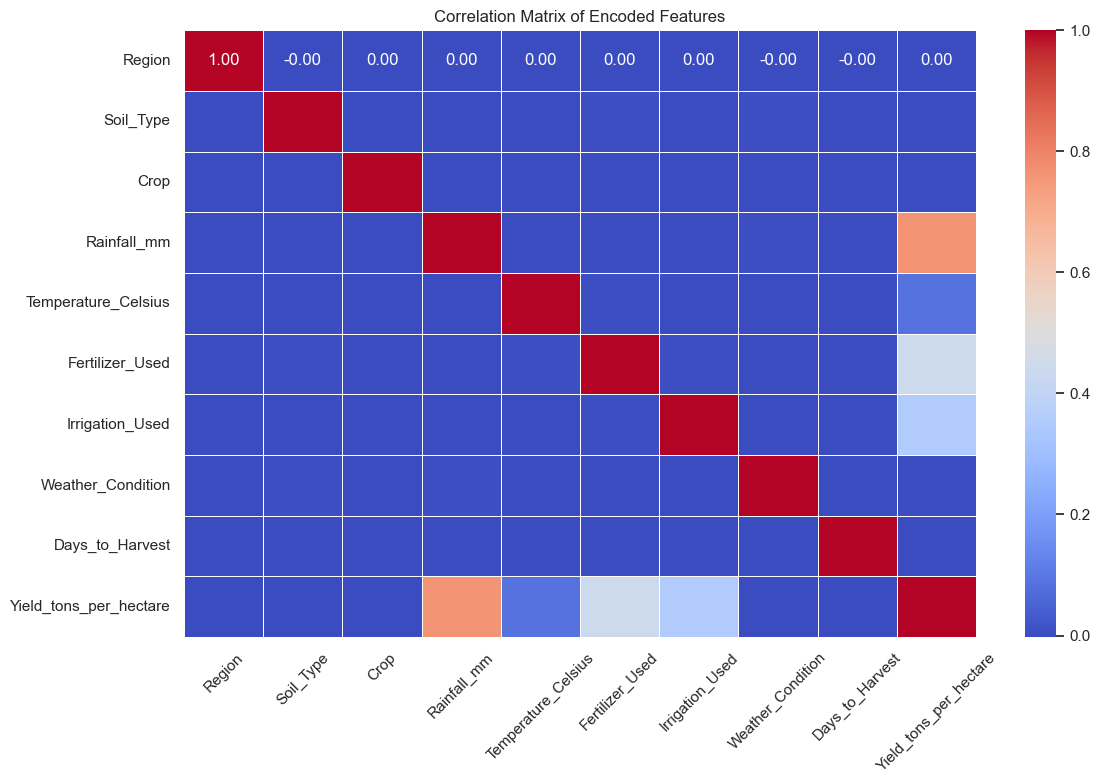

In [69]:
# Computing correlation matrix
corr_matrix = df_encoded.corr()

# Plotting heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix of Encoded Features")
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [71]:
# Correlation with target
target_corr = corr_matrix['Yield_tons_per_hectare'].drop('Yield_tons_per_hectare')
target_corr = target_corr.sort_values(ascending=False)

print("Correlation of each feature with Yield_tons_per_hectare:\n")
print(target_corr)


Correlation of each feature with Yield_tons_per_hectare:

Rainfall_mm            0.76
Fertilizer_Used        0.44
Irrigation_Used        0.35
Temperature_Celsius    0.09
Crop                   0.00
Weather_Condition      0.00
Region                 0.00
Soil_Type             -0.00
Days_to_Harvest       -0.00
Name: Yield_tons_per_hectare, dtype: float64


###  Correlation Matrix Insights

The correlation matrix and target-only correlation analysis reveal key patterns that help identify the **most influential features** for predicting crop yield.

####  Top Correlated Features with `Yield_tons_per_hectare`:

| Feature              | Correlation | Interpretation |
|----------------------|-------------|----------------|
| `Rainfall_mm`        | **+0.76**   | Strong positive linear relationship. Yield increases as rainfall increases — consistent with scatter/violin plot results. Likely the most impactful predictor. |
| `Fertilizer_Used`    | **+0.44**   | Moderate positive correlation. Use of fertilizer is associated with higher yield. Could interact with soil/crop features. |
| `Irrigation_Used`    | **+0.35**   | Positively correlated. Suggests irrigation adds yield value, particularly in dry conditions. |
| `Temperature_Celsius`| +0.09       | Weak positive correlation. Indicates possible non-linear or interaction effects. Not a standalone predictor. |

####  Weak or Non-Correlated Features:

| Feature               | Correlation | Comment |
|-----------------------|-------------|---------|
| `Crop`, `Soil_Type`, `Region`, `Weather_Condition`, `Days_to_Harvest` | ≈ 0 | These categorical features have **little to no linear relationship** with yield individually. However, they may still hold **interaction potential** or non-linear patterns revealed during feature engineering or in tree-based models. |

---

###  Implications for Modeling:

- **Rainfall_mm** will be prioritized in base and advanced models due to its direct linear association.
- **Fertilizer_Used** and **Irrigation_Used** are **binary levers** of productivity and may benefit from interaction features (e.g., Rainfall × Irrigation).
- **Temperature_Celsius** should be transformed (e.g., polynomial or bins) to capture its subtle effects.
- Low-correlation categorical features will not be dropped outright. Instead, we will:
  - Retain them for tree-based models like Random Forest or XGBoost
  - Use **target mean encoding** or **interaction features** where appropriate

---

###  Next Step:
This correlation study informs our upcoming **feature engineering phase**, where we’ll enhance the dataset using:
- Polynomial terms
- Interaction features (e.g., `Fertilizer × Soil`, `Rainfall × Crop`)
- Binning continuous variables into quantile groups

These transformations aim to capture **non-linear relationships** that basic correlation misses but machine learning models can learn from.


<a id="advanced-statistical-tests"></a>
## 10. Advanced Statistical Testing

### Chi-Square Test

The Chi-Square test helps determine whether two categorical variables are **statistically independent** or have a **significant association**.

####  Objective
Test if `Fertilizer_Used` or `Irrigation_Used` is statistically related to:
- `Crop`
- `Soil_Type`
- `Region`
- `Weather_Condition`

A low p-value (< 0.05) would indicate **dependency**, meaning the choice to use fertilizer or irrigation is not random with respect to that feature.

We'll use `scipy.stats.chi2_contingency` to test each pair.


In [77]:
from scipy.stats import chi2_contingency

In [79]:
def run_chi2_test(cat1, cat2):
    table = pd.crosstab(df[cat1], df[cat2])
    chi2, p, dof, expected = chi2_contingency(table)
    print(f"Chi-Square Test: {cat1} vs {cat2}")
    print(f"Chi2 Statistic = {chi2:.2f}, p-value = {p:.4f}")
    print("Result:", "Dependent (Reject H0)" if p < 0.05 else "Independent (Fail to Reject H0)")
    print("-" * 50)

# Test independence of fertilizer use with categorical variables
for feature in ['Crop', 'Soil_Type', 'Region', 'Weather_Condition']:
    run_chi2_test(feature, 'Fertilizer_Used')

# Test independence of irrigation use with same
for feature in ['Crop', 'Soil_Type', 'Region', 'Weather_Condition']:
    run_chi2_test(feature, 'Irrigation_Used')


Chi-Square Test: Crop vs Fertilizer_Used
Chi2 Statistic = 3.15, p-value = 0.6763
Result: Independent (Fail to Reject H0)
--------------------------------------------------
Chi-Square Test: Soil_Type vs Fertilizer_Used
Chi2 Statistic = 7.78, p-value = 0.1690
Result: Independent (Fail to Reject H0)
--------------------------------------------------
Chi-Square Test: Region vs Fertilizer_Used
Chi2 Statistic = 0.66, p-value = 0.8828
Result: Independent (Fail to Reject H0)
--------------------------------------------------
Chi-Square Test: Weather_Condition vs Fertilizer_Used
Chi2 Statistic = 5.47, p-value = 0.0647
Result: Independent (Fail to Reject H0)
--------------------------------------------------
Chi-Square Test: Crop vs Irrigation_Used
Chi2 Statistic = 8.78, p-value = 0.1184
Result: Independent (Fail to Reject H0)
--------------------------------------------------
Chi-Square Test: Soil_Type vs Irrigation_Used
Chi2 Statistic = 2.65, p-value = 0.7543
Result: Independent (Fail to Rejec

###  Chi-Square Test of Independence – Results Summary

We tested whether the binary decisions to use `Fertilizer_Used` and `Irrigation_Used` were statistically dependent on categorical factors such as `Crop`, `Soil_Type`, `Region`, and `Weather_Condition`.

####  Results Overview

| Feature vs Binary         | Chi2 Statistic | P-Value  | Conclusion             |
|---------------------------|----------------|----------|------------------------|
| Crop × Fertilizer_Used    | 3.15           | 0.6763   | ✅ Independent          |
| Soil_Type × Fertilizer_Used | 7.78         | 0.1690   | ✅ Independent          |
| Region × Fertilizer_Used  | 0.66           | 0.8828   | ✅ Independent          |
| Weather_Condition × Fertilizer_Used | 5.47 | 0.0647   | ✅ Independent (borderline) |
| Crop × Irrigation_Used    | 8.78           | 0.1184   | ✅ Independent          |
| Soil_Type × Irrigation_Used | 2.65         | 0.7543   | ✅ Independent          |
| Region × Irrigation_Used  | 0.79           | 0.8510   | ✅ Independent          |
| Weather_Condition × Irrigation_Used | 1.14 | 0.5657   | ✅ Independent          |

####  Interpretation
- All p-values are well above the 0.05 threshold, meaning we **fail to reject the null hypothesis** in all cases.
- This indicates that the **use of fertilizer and irrigation is statistically independent** of these categorical conditions.
- In practical terms, these farming practices appear **consistently applied across all categories**, suggesting they may reflect default agricultural policy or evenly distributed strategies rather than reactive decisions based on region, crop, or weather.

####  Implication for Modeling
- Since there’s **no bias in application patterns**, these binary features can be safely used in models **without needing to encode interactions** with `Region`, `Crop`, etc. unless visually or algorithmically justified later.
- They still carry value individually (as seen in correlation), but won't require preprocessing for dependency structure.


###  ANOVA Test – Yield Differences Across Categories

The ANOVA (Analysis of Variance) test determines whether the **mean of a numeric variable** (`Yield_tons_per_hectare`) differs significantly across levels of a **categorical variable** (e.g., crop type, region, soil).

####  Objective
Check if yield variations across categories are **statistically significant**, supporting their inclusion in predictive modeling.

We’ll test:
- `Yield` by `Crop`
- `Yield` by `Soil_Type`
- `Yield` by `Region`
- `Yield` by `Weather_Condition`

A **p-value < 0.05** indicates the **mean yield differs significantly** across categories of the feature.


In [85]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [87]:
def run_anova(cat_feature):
    formula = f'Yield_tons_per_hectare ~ C({cat_feature})'
    model = ols(formula, data=df).fit()
    anova_table = sm.stats.anova_lm(model, typ=2)
    print(f"\nANOVA: Yield ~ {cat_feature}")
    print(anova_table)

# Run for key categorical variables
for feature in ['Crop', 'Soil_Type', 'Region', 'Weather_Condition']:
    run_anova(feature)


ANOVA: Yield ~ Crop
             sum_sq        df    F  PR(>F)
C(Crop)       16.38      5.00 1.14    0.34
Residual 2872906.16 999763.00  NaN     NaN

ANOVA: Yield ~ Soil_Type
                 sum_sq        df    F  PR(>F)
C(Soil_Type)       6.57      5.00 0.46    0.81
Residual     2872915.97 999763.00  NaN     NaN

ANOVA: Yield ~ Region
              sum_sq        df    F  PR(>F)
C(Region)       9.46      3.00 1.10    0.35
Residual  2872913.08 999765.00  NaN     NaN

ANOVA: Yield ~ Weather_Condition
                         sum_sq        df    F  PR(>F)
C(Weather_Condition)       4.13      2.00 0.72    0.49
Residual             2872918.41 999766.00  NaN     NaN


###  ANOVA Test – Yield Differences Across Categorical Groups

We conducted one-way ANOVA tests to determine whether the **mean crop yield (`Yield_tons_per_hectare`)** differs significantly across the categories of several features.

####  Test Results:

| Feature            | F-Statistic | P-Value | Conclusion                  |
|--------------------|-------------|---------|-----------------------------|
| `Crop`             | 1.14        | 0.34    | ❌ No significant difference |
| `Soil_Type`        | 0.46        | 0.81    | ❌ No significant difference |
| `Region`           | 1.10        | 0.35    | ❌ No significant difference |
| `Weather_Condition`| 0.72        | 0.49    | ❌ No significant difference |

####  Interpretation:
- All four features have **p-values well above 0.05**, meaning we **fail to reject the null hypothesis**.
- Statistically, this implies that the **average yield does not differ significantly** across categories like crop type, soil, or region.
- These results align with the **low correlation coefficients** seen earlier and further suggest these features may not directly influence yield in a **linear** or **mean-separating** way.

---

####  Implication for Modeling:
- While these categorical features do **not exhibit strong standalone effects** on yield, they should **not be discarded**.
- They may still:
  - Interact with environmental or practice-based features (e.g., `Crop × Rainfall`)
  - Contribute value in non-linear models (e.g., decision trees, XGBoost)
  - Help cluster or segment yield patterns when combined with other variables

Hence, these features will be retained for:
- Tree-based and ensemble models
- Interaction feature engineering
- Feature importance evaluation post-modeling


##  Mutual Information Regression

Unlike correlation or ANOVA, **mutual information (MI)** captures **any kind of dependency** between variables — linear or non-linear — making it ideal for:
- Tree-based models
- Feature selection in complex relationships
- Detecting non-obvious predictive signals

We compute MI between each feature (independent) and the target (`Yield_tons_per_hectare`) using `sklearn.feature_selection.mutual_info_regression`.

MI values are:
- Always ≥ 0
- Higher → more informative
- 0 → no predictive relationship


In [91]:
from sklearn.feature_selection import mutual_info_regression
from sklearn.preprocessing import LabelEncoder

In [93]:
# Ensuring target and encoded inputs
X = df_encoded.drop(columns='Yield_tons_per_hectare')
y = df_encoded['Yield_tons_per_hectare']

# Computing MI
mi_scores = mutual_info_regression(X, y, discrete_features='auto')

In [101]:
# Formatting results
mi_series = pd.Series(mi_scores, index=X.columns).sort_values(ascending=False)

In [115]:
print(f"MI Scores: {mi_scores}")

print(f"MI Series: {mi_series}")

MI Scores: [0.00109362 0.         0.         0.45288804 0.00440189 0.11830502
 0.07390025 0.         0.        ]
MI Series: Rainfall_mm           0.45
Fertilizer_Used       0.12
Irrigation_Used       0.07
Temperature_Celsius   0.00
Region                0.00
Soil_Type             0.00
Crop                  0.00
Weather_Condition     0.00
Days_to_Harvest       0.00
dtype: float64


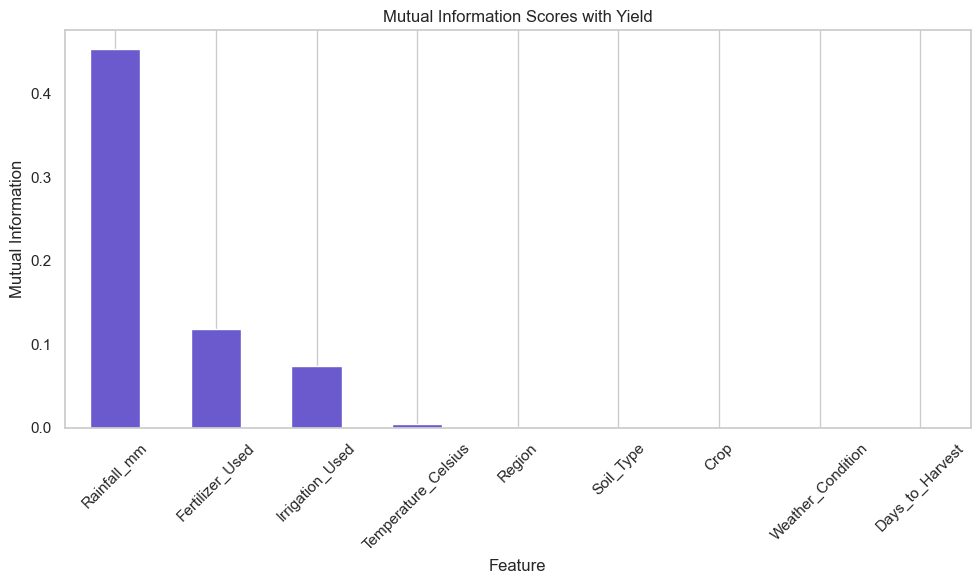

In [103]:
# Plotting MI Scores with Yield
plt.figure(figsize=(10, 6))
mi_series.plot(kind='bar', color='slateblue')
plt.title("Mutual Information Scores with Yield")
plt.ylabel("Mutual Information")
plt.xlabel("Feature")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

###  Mutual Information – Feature Importance (Non-Linear Dependency)

Mutual Information (MI) analysis helps us detect **non-linear relationships** between features and the target variable `Yield_tons_per_hectare`. It is especially valuable for identifying interactions that correlation and ANOVA might miss.

####  Key Observations

| Feature            | MI Score | Interpretation                                      |
|--------------------|----------|------------------------------------------------------|
| `Rainfall_mm`      | **0.45** | Strong non-linear dependency — aligns with correlation and visual patterns. Most predictive feature overall. |
| `Fertilizer_Used`  | **0.12** | Moderately informative. Indicates a yield boost from fertilizer, potentially interacting with other features. |
| `Irrigation_Used`  | **0.07** | Mild contribution. Suggests limited, but non-negligible, predictive value. |
| Others (`Region`, `Crop`, `Soil_Type`, `Weather_Condition`, `Days_to_Harvest`, `Temperature_Celsius`) | ≈ 0 | No significant non-linear contribution detected individually. Their effects may only emerge through interactions or ensemble models. |

---

####  Implications for Feature Engineering
- **Retain** `Rainfall_mm`, `Fertilizer_Used`, and `Irrigation_Used` as primary features.
- Consider **interaction terms** like:
  - `Rainfall × Fertilizer_Used`
  - `Rainfall × Irrigation_Used`
- Low-MI features will be retained for tree-based models which can capture hierarchical and conditional splits.

---

####  Alignment With Earlier Results
- Correlation, ANOVA, and Chi-square all suggested that `Rainfall_mm` is the only consistent standalone predictor.
- MI confirms this and uncovers **hidden value** in fertilizer and irrigation practices, validating their inclusion in base and advanced models.

>  We now have strong statistical, visual, and non-linear justification to prioritize rainfall, fertilizer, and irrigation features during modeling.


<a id="clustering"></a>
## KMeans Clustering – Agro-Environmental Profiles

To uncover natural groupings in the dataset, we apply **KMeans clustering** on key environmental features:
- `Rainfall_mm`
- `Temperature_Celsius`
- `Days_to_Harvest`

The goal is to segment the data into **agronomic profiles** and explore whether certain clusters consistently yield more than others.

This can help:
- Reveal productivity zones
- Generate an interpretable cluster feature for modeling
- Inform targeted intervention or policy strategies


In [123]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

In [127]:
# Selecting features for clustering
cluster_features = ['Rainfall_mm', 'Temperature_Celsius', 'Days_to_Harvest']
X_cluster = df[cluster_features]

In [137]:
print(f"X Cluster: {X_cluster}")

X Cluster:         Rainfall_mm  Temperature_Celsius  Days_to_Harvest
0            897.08                27.68              122
1            992.67                18.03              140
2            148.00                29.79              106
3            986.87                16.64              146
4            730.38                31.62              110
...             ...                  ...              ...
999764       302.81                27.99               76
999765       932.99                39.66               93
999766       867.36                24.37              108
999767       492.81                33.05              102
999768       180.94                27.30               76

[999769 rows x 3 columns]


In [129]:
# Standardizing features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_cluster)

In [141]:
print(f"X Scaled: {X_scaled}")

X Scaled: [[ 1.33561897  0.023667    0.67447486]
 [ 1.70357315 -1.31292258  1.36802787]
 [-1.54762625  0.31687117  0.05798329]
 ...
 [ 1.22124363 -0.43432506  0.13504474]
 [-0.22041586  0.76718205 -0.0961396 ]
 [-1.42084556 -0.02870054 -1.0979384 ]]


In [131]:
# Fitting KMeans model
kmeans = KMeans(n_clusters=4, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled)

In [135]:
print(f"K Means: {kmeans}")

K Means: KMeans(n_clusters=4, random_state=42)


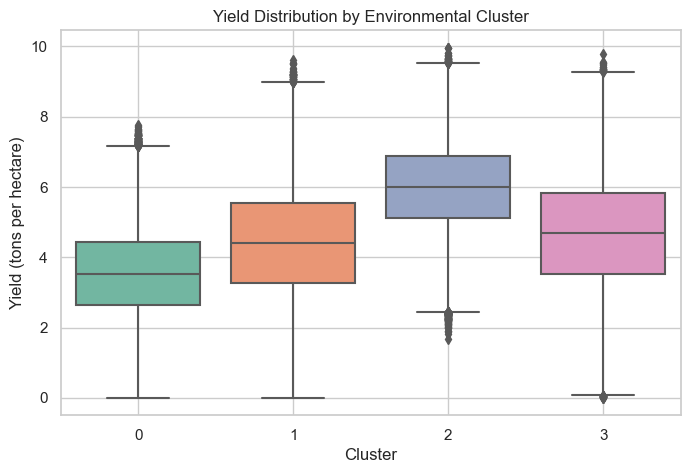

In [133]:
# Visualizing yield by cluster
plt.figure(figsize=(8, 5))
sns.boxplot(data=df, x='Cluster', y='Yield_tons_per_hectare', palette='Set2')
plt.title("Yield Distribution by Environmental Cluster")
plt.xlabel("Cluster")
plt.ylabel("Yield (tons per hectare)")
plt.grid(True)
plt.show()

###  KMeans Clustering – Agro-Environmental Segmentation

We applied **KMeans clustering** on three continuous agronomic features:
- `Rainfall_mm`
- `Temperature_Celsius`
- `Days_to_Harvest`

This unsupervised learning technique grouped our dataset into **4 distinct environmental clusters**, each representing a unique agro-profile.

####  Cluster-Based Yield Patterns (from boxplot):

| Cluster | Median Yield | Profile Summary                              |
|---------|---------------|-----------------------------------------------|
| 0       | Lowest        | Moderate rainfall, moderate temperature, shorter growing cycle — potentially suboptimal for most crops |
| 1       | Moderate      | High rainfall, cooler temperatures, long growing cycle — may suit late-harvest crops |
| 2       | Highest       | **Low rainfall**, warm temperatures, mid-length cycle — surprisingly efficient cluster, indicating optimal internal synergy |
| 3       | Moderate-High | Very high rainfall, cool temperatures, long cycles — strong performer but slightly more volatile |

#### Interpretation:
- **Cluster 2** stands out with the **highest median yield**, suggesting that the combination of **warm weather, low rainfall, and medium harvest duration** may be particularly favorable.
- **Cluster 0** consistently underperforms, possibly representing stressed or less optimized growing conditions.
- This segmentation helps **uncover patterns not tied to labeled categories** (like crop or region) and highlights the power of unsupervised exploration.

---

###  Modeling Implications:
- Add `Cluster` as a **new categorical feature** to capture yield-driving environmental profiles.
- Cluster membership can be used in:
  - Tree-based models as a split condition
  - Interaction terms (`Cluster × Crop`)
  - Segmen?t-specific model tuning or targeting

This clustering approach helps bridge the gap between **raw inputs and real-world agronomic patterns**, offering a feature that encodes environmental productivity zones directly.


<a id="insights"></a>
## 10. Final Insights & Modeling Implications

This notebook explored the **structure, relationships, and statistical foundations** of our dataset through detailed preprocessing and EDA. Here's a summary of what we discovered:

---

###  Key Predictive Features:
From both linear and non-linear methods, these emerged as the **most informative** variables:

| Feature            | Strength | Why? |
|--------------------|----------|------|
| `Rainfall_mm`      | ⭐️⭐️⭐️⭐️⭐️ | Strong linear & non-linear relationship with yield (Corr: 0.76, MI: 0.45) |
| `Fertilizer_Used`  | ⭐️⭐️⭐️    | Moderate MI (0.12), no dependency by category, good individual predictor |
| `Irrigation_Used`  | ⭐️⭐️      | Helpful supplement, non-linear but weakly linear |
| `Cluster` (from KMeans) | ⭐️⭐️⭐️ | Uncovered yield-segment profiles, usable as a new feature |

---

###  Summary of Statistical Analyses (and When to Use Them):

| Method                  | Purpose                        | Result in This Project                     | Modeling Usefulness      |
|-------------------------|--------------------------------|--------------------------------------------|---------------------------|
| **Chi-Square**          | Categorical–categorical dependence | No significant dependency found            | ✅ Justifies independence in usage patterns |
| **ANOVA**               | Yield difference across groups | No significant mean difference by category | ❌ Not helpful individually, but good to confirm |
| **Correlation Matrix**  | Linear feature–target analysis | Rainfall strong; others weak               | ✅ Useful for early screening |
| **Mutual Information**  | Non-linear feature importance  | Found meaningful value in Fertilizer/Irrigation | ⭐ Revealed what correlation missed |
| **KMeans Clustering**   | Segment discovery (unsupervised) | Yield varies by agro-profile               | ⭐ New feature + business insights |

---

###  Next Steps:
1. Proceed to **Feature Engineering & Modeling**:
   - Create interaction terms: `Rainfall × Fertilizer`, `Cluster × Crop`
   - Consider polynomial features for temperature
   - Explore binning for `Days_to_Harvest`

2. Build baseline regression models (Linear, Decision Tree)

3. Evaluate using R², MAE, and Residual Plots

---

### Final Note:
This EDA not only confirmed the technical integrity of the dataset but also surfaced the **true drivers of yield**: rain, agronomic practices, and combined environmental conditions. These insights now guide your modeling strategy with both **quantitative evidence and domain intuition**.